# Image to Image Diffusion

In this notebook, we take a look at Image to Image Diffusion.

### Install and Import required packages

In [ ]:
!pip install stablefused ipython

In [ ]:
import numpy as np
import torch

from IPython.display import Video, display
from PIL import Image
from stablefused import ImageToImageDiffusion
from stablefused.utils import image_grid, pil_to_video

### Initialize model and parameters

We use RunwayML's Stable Diffusion 1.5 checkpoint and initialize our Image To Image Diffusion model, and some other parameters. Play around with different prompts and input images, and see what you get! You can comment out the seed part if you want to generate new random images each time you run the notebook.

We use the following mechanism to trade-off speed for reduced memory footprint. It allows us to work with bigger images and larger batch sizes with about just 6GB of GPU memory.
- U-Net Attention Slicing: Allows the internal U-Net model to perform computations for attention heads sequentially, rather than in parallel.
- VAE Slicing: Allow tensor slicing for VAE decode step. This will cause the vae to split the input tensor to compute decoding in multiple steps.
- VAE Tiling: Allow tensor tiling for vae. This will cause the vae to split the input tensor into tiles to compute encoding/decoding in several steps.

In [ ]:
model_id = "runwayml/stable-diffusion-v1-5"
model = ImageToImageDiffusion(model_id=model_id, torch_dtype=torch.float16)
model.enable_attention_slicing()
model.enable_slicing()
model.enable_tiling()

##### The Renaissance Astronaut

We will be using this as our input image.

Image credits: https://mspoweruser.com/best-stable-diffusion-prompts/

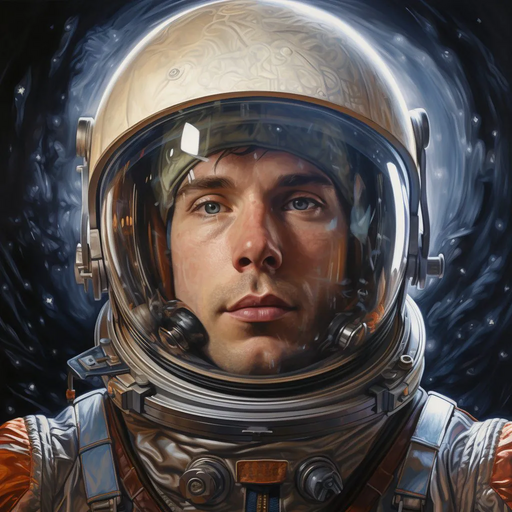

In [ ]:
prompt = "Cartoon-like portrait, drawn by a child, of a male astronaut in space, colorful, funky, crazy"
negative_prompt = "cartoon, unrealistic, blur, boring background, deformed, disfigured, low resolution, unattractive"
num_images = 4
seed = 31337

torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
filename = "the-renaissance-astronaut.png"
start_image = [Image.open(filename)] * num_images

# This step is only required when loading model with torch.float16 dtype
start_image = np.array(start_image, dtype=np.float16)

### Inference

We provide our starting image as a base and ask the model to generate similar images, but aligning it to our prompt. You can run the stable diffusion inference using the call method `()` or the `.generate()` method. Refer to the documentation to see what parameters can be provided.

In [ ]:
images = model(
    image=start_image,
    prompt=[prompt] * num_images,
    negative_prompt=[negative_prompt] * num_images,
    num_inference_steps=30,
    start_step=5,
    guidance_scale=15.0,
)

In [ ]:
image_grid(images, rows=2, cols=2)

### Visualizing the diffusion process

In [ ]:
prompt = [
    "High quality and colorful photo of Robert J Oppenheimer, father of the atomic bomb, in a spacesuit, galaxy in the background, universe, octane render, realistic, 8k, bright colors",
    "Stylistic photorealisic photo of Margot Robbie, playing the role of astronaut, pretty, beautiful, high contrast, high quality, galaxies, intricate detail, colorful, 8k",
]
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
num_images = len(prompt)
filename = "the-renaissance-astronaut.png"
start_image = [Image.open(filename)] * num_images

# This step is only required when loading model with torch.float16 dtype
start_image = np.array(start_image, dtype=np.float16)

In [ ]:
images = model(
    image=start_image,
    prompt=prompt,
    negative_prompt=[negative_prompt] * len(prompt),
    num_inference_steps=30,
    start_step=8,
    guidance_scale=12.0,
    return_latent_history=True,
)

In [ ]:
timestep_images = []
for imgs in zip(*images):
    img = image_grid(imgs, rows=1, cols=len(prompt))
    timestep_images.append(img)

In [ ]:
path = "image_to_image_diffusion.mp4"
pil_to_video(timestep_images, path, fps=5)

Tada!

In [ ]:
display(Video(path, embed=True))